# 1D Hopper Example 
This notebook goes through how to set up and solve a trajectory optimization problem for a simple hybrid system: a 1D hopper that jumps up and down. The key takeaway for setting up hybrid problems is properly defining the constraints, mode sequence, and dynamics so that the solver understands which kind of dynamics is available at each time step.

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
using LinearAlgebra
using Plots
using ForwardDiff
using Ipopt
using MathOptInterface
using StaticArrays
const MOI = MathOptInterface;
using TrajectoryOptimization
using Altro
using RobotDynamics
# Meshcat Stuff
using Colors
using CoordinateTransformations
using GeometryBasics
using MeshCat
using Rotations

 Activating environment at `C:\Users\brand\OneDrive\Documents\College Stuff\Research notes\REx\TrajectoryOptimization.jl\examples\Hybrid Examples\Project.toml`


## Defining the dynamics
The easiest way to combine the hybrid approach with `TrajectoryOptimization.jl` is to define the variables which differ between dynamic modes (in the 1D Hopper case, the contact force between the ground and the foot) as a control input to the system. This way, we can properly constrain it in the solver more easily. For this reason, we define the dynamics ourselves and integrate it into the `RobotDynamics.jl` framework.
## The Model
The diagram of the working model is shown below (INSERT THE PICTURE SOME TIME). We assume a model of two point masses connected by a prismatic joint to simplify the dynamics. A simple free-body diagram allows us to calculate the forces and accelerations on each mass:

$$ \begin{align}
   F_{h} &= F_{j} - m_{h}g \\
   F_{f} &= F_{c} - m_{f}g - F_{j} \\
   a_{h} &= \frac{F_{j}}{m_{h}} - g \\
   a_{f} &= \frac{F_{c}}{m_{f}} - \frac{F_{j}}{m_{f}} - g\\
   \end{align}$$

Our state variables and control inputs are defined below:
$$ x = \begin{bmatrix}
        z_{head}\\
        z_{foot}\\
        \dot z_{head}\\
        \dot z_{foot}\\
        \end{bmatrix}$$ 
        
$$ u = \begin{bmatrix}
       F_{j}\\
       F_{c}\\
       \end{bmatrix}$$

Finally, we split our dynamics into two phases: the stance phase and the flight phase. When in stance phase, we consider the foot to be pinned to the ground. In flight phase, the robot falls without experience contact forces.

In [2]:
# Dead simple hopper
function ez_dynamics(x, u)
    # x is a 4d vec, u is a 2d vec
    mh = 1.0
    mf = 1.0
    g = 9.81
    v = x[3:4]
    FLeg = u[1]
    FCon = u[2]
    xdd = [v; FLeg / mh - g; (FCon - FLeg)/mh - g]
end

function ez_dynamics_rk4(x, u, h)
    #RK4 integration with zero-order hold on u
    f1 = ez_dynamics(x, u)
    f2 = ez_dynamics(x + 0.5*h*f1, u)
    f3 = ez_dynamics(x + 0.5*h*f2, u)
    f4 = ez_dynamics(x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

ez_dynamics_rk4 (generic function with 1 method)

## Creating the model
Using the dynamics we defined above, along with the `RobotDynamics.jl` interface, we define a model for our hopper.

In [3]:
struct Hoppity <: AbstractModel end
RobotDynamics.state_dim(::Hoppity) = 4
RobotDynamics.control_dim(::Hoppity) = 2

function RobotDynamics.dynamics(::Hoppity,x,u)
    ẋ = ez_dynamics(x, u)
end

## Setting up the Visualizer 
The code below defines the animation for the visualizer and creates the visualizer instance. To produce a trajectory in the visualizer, simply call the function ``` visualize!(visualizer_instance_name, trajectory_to_visualize_name, time_step_length_name) ```

In [4]:
vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8704
└ @ MeshCat C:\Users\brand\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8704))

In [5]:
function kinematics(x)
    return [x[1], x[2]]
end

function visualize!(vis, Xs, h)
    r_body = 0.2
    r_foot = 0.1
    r_leg = 0.5*r_foot
    
    setvisible!(vis["/Background"], true)
    headSphere = Sphere(Point3f0(0), convert(Float32, r_body))
    footSphere = Sphere(Point3f0(0), convert(Float32, r_foot))
    legSphere = Sphere(Point3f0(0), convert(Float32, r_leg))
    setobject!(vis["body"], headSphere, MeshPhongMaterial(color = RGBA(1.0, 0.0, 1.0, 1.0)))
    setobject!(vis["foot"], footSphere, MeshPhongMaterial(color = RGBA(1.0, 1.0, 0.0, 1.0)))
    
    n_leg = 100
    for i = 1:n_leg
        setobject!(vis["leg$i"], legSphere, MeshPhongMaterial(color=RGBA(0.0, 0.0, 0.0, 1.0)))
    end
    
    p_leg = [zeros(3) for i = 1:n_leg]
    
    anim = MeshCat.Animation(convert(Int, floor(1.0 / h)))
    
    for t = 1:length(Xs)
        x = Xs[t]
        p_body = [0.0, 0.0, x[1]]
        p_foot = [0.0, 0.0, x[2]]
        zDist = x[1] - x[2]
        
        z_shift = [0.0, 0.0, r_foot]
        
        for i = 1:n_leg
            p_leg[i] .= [0.0, 0.0, zDist/n_leg*i + x[2]]
        end
        
        
        
        MeshCat.atframe(anim, t) do 
            settransform!(vis["body"], Translation(p_body + z_shift))
            settransform!(vis["foot"], Translation(p_foot + z_shift))
            
            for i = 1:n_leg
                settransform!(vis["leg$i"], Translation(p_leg[i] + z_shift))
            end
        end
    end
    MeshCat.setanimation!(vis, anim)
end

visualize! (generic function with 1 method)

## Simple series of hops
The following code solves for a trajectory that performs ten short hops in a row. Note that in this example, the number of timesteps in the stance and flight phases is the same (five timesteps each). The reference trajectory is displayed below:

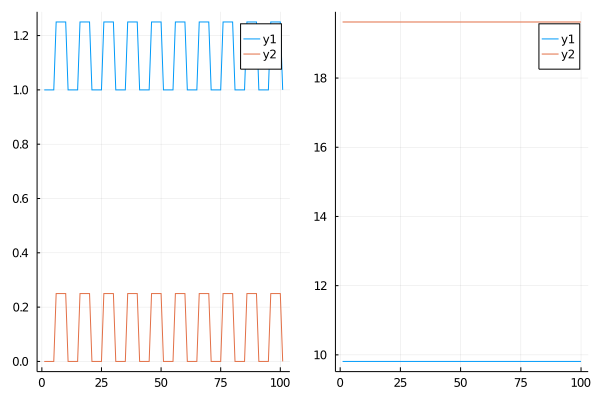

In [38]:
begin 
    # Create the model and define useful variables
    model = Hoppity()
    n = state_dim(model)  
    m = control_dim(model)
    N = 101 # Total number of timesteps for entire trajectory
    mSteps = 5
    g = 9.81
    
    iState = 1
    next = 1
    modeList = zeros(1, N)
    for i = 1:N
        modeList[i] = iState
        if mod(i, mSteps) == 0
            iState += next
            next *= -1
        end
    end
    
    xRefSimp = zeros(n, N)
    xRefSimp[1, :] .= 1.0
    
    for i = 2:N
        if modeList[i] == 1
            xRefSimp[1, i] = 1.0
            xRefSimp[2, i] = 0.0
        else
            xRefSimp[1, i] = 1.25
            xRefSimp[2, i] = 0.25
        end
    end

    xRefSimp[:, end] .= xRefSimp[:, 1]
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
        
    ueq = [g; 2*g]
    URefSimp = zeros(m, N-1)
    for i = 1:N-1
        uRefSimp[:, i] .= ueq
    end
    URefSimp = [SVector{m}(uRefSimp[:, i]) for i = 1:N-1]
    p1 = plot(XRefSimp, inds=1:2)
    p2 = plot(URefSimp, inds=1:2)
    plot(p1, p2, layout=(1, 2))
end

The problem presented is solved using `ALTRO`. For more information on getting started with the solver, please visit https://github.com/RoboticExplorationLab/Altro.jl


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 19
    Solve Time: 194.38739999999999 (ms)

  Covergence
    Terminal Cost: 22084.354353362585
    Terminal dJ: -0.0006594414298888296
    Terminal gradient: 202.78261915884374
    Terminal constraint violation: 1.5508770993892441e-6
    Solve Status: SOLVE_SUCCEEDED


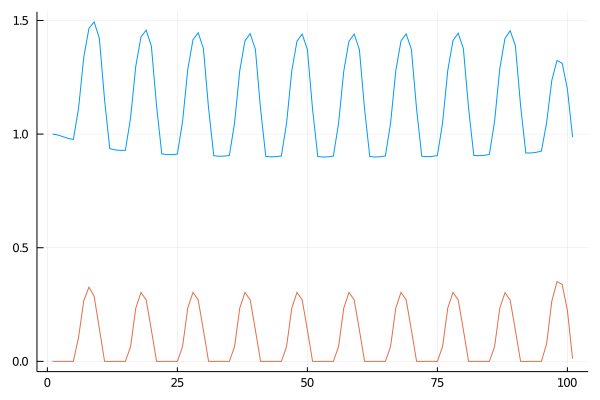

In [47]:
begin
    # Create the model and define useful variables
    model = Hoppity()
    n = state_dim(model)  
    m = control_dim(model)
    N = 101 # Total number of timesteps for entire trajectory
    mSteps = 5 # Number of time steps in each dynamics phase
    g = 9.81 # Define gravitational acceleration
    ueq = [g, 2*g] # Define controls to maintain an equilibrium state 
    h = 0.1 # Time between each timestep (0.1 seconds)
    
    
    # This next section sets up an array of length N, where each entry represents the mode at that timestep
    # Stance phase is represented by 1.0, while the flight phase is represented by 2.0'
    iState = 1
    next = 1
    modeList = zeros(1, N)
    for i = 1:N
        modeList[i] = iState
        if mod(i, mSteps) == 0
            iState += next
            next *= -1
        end
    end
    
    
    # To properly enforce the hybrid dynamics, we need to enforce the constraints explained when we defined the model
    # The constraints we want are: 
    #     - in stance, set the foot height to be 0 (Linear Constraint)
    #     - in flight, set the constraint forces to be 0 (Linear Constraint)
    # For these constraints, a knot point is defined as a vector of [state variables; control inputs] as defined above
    
    # Create the list of constraints
    conSet = ConstraintList(n, m, N)
    
    # Create stance constraints
    A2 = zeros(1, n)
    A2[1, 2] = 1.0 # Matrix to extract foot height
    b2 = SVector{1}([0.0])
    stnc = LinearConstraint(n, m, A2, b2, Equality(), 1:n) # Enforces constraint on state variables 
    
    # Create flight constraints
    A3 = zeros(1, m)
    A3[1, 2] = 1.0 # Matrix to extract contact forces
    b3 = SVector{1}(0.0)
    flgt = LinearConstraint(n, m, A3, b3, Equality(), (n+1):(n+m)) # Enforces constraints on control inputs
    
    
    # Add the constraints to the constraint list, depending on what mode the timestep corresponds to in the mode list
    for i = 1:N-1
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        else
            add_constraint!(conSet, flgt, i)
        end
    end
    

    # Defining the reference trajectory. This trajectory matches the one shown in the cell above this one.
    xRefSimp = zeros(n, N)
    xRefSimp[1, :] .= 1.0

    for i = 2:N
        if modeList[i] == 1
            xRefSimp[1, i] = 1.0
            xRefSimp[2, i] = 0.0
        else
            xRefSimp[1, i] = 1.25
            xRefSimp[2, i] = 0.25
        end
    end

    # Convert the trajectory to a form required by the LQRCosts function and the ALTRO solver
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    
    
    # Creating the cost function. Q and R represents the stage cost on the state variables 
    # and control inputs respectively, while Qf represents the terminal cost on the state variables.
    # For this problem we simply apply a time-varying LQR cost.
    
    Q = 1000.0 * [1.0 0.0 0.0 0.0;
         0.0 1.0 0.0 0.0;
         0.0 0.0 1.0 0.0;
         0.0 0.0 0.0 1.0]
    
    Qf = 75.0*[1.0 0.0 0.0 0.0;
                0.0 1.0 0.0 0.0;
                0.0 0.0 1.0 0.0;
                0.0 0.0 0.0 1.0]
    
    R = 0.1*[1.0 0.0;
             0.0 1.0]
    
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    
    # Initialize the problem and solve using ALTRO. 
    # For more information, please see the ALTRO repository linked above.
    prob_hop = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    
    # Initialize the controls with the equilibrium input
    initial_controls!(prob_hop, URefSimp[1])
    rollout!(prob_hop)
    
    # Run the solver
    solver = ALTROSolver(prob_hop)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    # Send the trajectory to the visualizer
    visualize!(vis, solveX, h)
    
    # Plot the solved trajectory
    plot(solveX, inds=1:2, legend=false)
end
    

## Bobbing

In [ ]:
# Bobbing head up and down
begin
    n = 4
    m = 2
    N = 21
    mSteps = 5
    
    x = zeros(n)
    g = 9.81
    ueq = [g, 2*g]
    model = Hoppity()
    
    conSet = ConstraintList(n, m, N)
    h = 0.1
    modeSteps = 5
    modeList = zeros(N)

    iState = 1
    next = 1
    for i = 1:N
        modeList[i] = iState
        if mod(i, modeSteps) == 0
            iState += next
            next *= -1
        end
    end
    
    xRefSimp = zeros(n, N)
    xRefSimp[1, :] .= 1.0
    uRefSimp = zeros(m, N-1)

    for i = 1:N
#         if modeList[i] == 2
#             xRefSimp[1, i] = 1.25
#             xRefSimp[2, i] = 0.0
#         end
        xRefSimp[1, i] = 1.0 - 0.25*sin(pi/modeSteps*(i-1))
        xRefSimp[3, i] = -0.25*cos(pi/modeSteps*(i-1)) * pi/modeSteps
    end

    xRefSimp[:, end] .= xRefSimp[:, 1]

    plot(xRefSimp[1, :])
    plot!(xRefSimp[2, :])
    
    # The constraints we want are: 
    # 1) don't let the foot and head get too far away for all timesteps (Linear Constraint)
    # 2) in stance, set the foot height to be 0 (Linear Constraint)
    # 3) in flight, set the control height to be 0 (Linear Constraint)
    
#     # At all times
#     A1 = zeros(1, n)
#     A1[1, 1] = -1.0
#     A1[1, 2] = 1.0
#     b1 = SVector{1}(0.0)
#     cont = LinearConstraint(n, m, A1, b1, Inequality(), 1:n)
#     add_constraint!(conSet, cont, 1:N-1)
#     # add_constraint!(conSet, stnc, N)
    
    # Stance ones
    A2 = zeros(1, n)
    # A2[1, 1] = 1.0
    A2[1, 2] = 1.0
    b2 = SVector{1}([0.0])
    stnc = LinearConstraint(n, m, A2, b2, Equality(), 1:n)
    
#     # add_constraint!(conSet, stnc, N)
    
    # Flight ones
#     A3 = zeros(1, m)
#     A3[1, 2] = 1.0
#     b3 = SVector{1}(0.0)
#     flgt = LinearConstraint(n, m, A3, b3, Equality(), (n+1):(n+m))
    
    for i = 1:N-1
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
#         else
#             add_constraint!(conSet, flgt, i)
        end
    end
        
    
    Q = 100.0 * [1.0 0.0 0.0 0.0;
         0.0 1.0 0.0 0.0;
         0.0 0.0 1.0 0.0;
         0.0 0.0 0.0 1.0]
    
    Qf = 10.0*[1.0 0.0 0.0 0.0;
                0.0 1.0 0.0 0.0;
                0.0 0.0 1.0 0.0;
                0.0 0.0 0.0 1.0]
    
    # intln(typeof())
    R = 0.01*[1.0 0.0;
             0.0 1.0]
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    costs = [LQRCost(Q, R, XRefSimp[i], URefSimp[i]) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    
    prob_hop = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob_hop, URefSimp[1])
    rollout!(prob_hop)
    
#     opts = SolverOptions(
#     cost_tolerance_intermediate=1e-2,
#     penalty_scaling=10.,
#     penalty_initial=1.0
#     )
    
    solver = ALTROSolver(prob_hop)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    println(solveU)
    
    p1 = plot(solveX, inds=1:2)
    p2 = plot(XRefSimp, inds=1:2)
    visualize!(vis, solveX, h)
    plot(p1, p2, layout = (1, 2), legend=false)
end
    
    
    

## Retracting

In [ ]:
# Several Hops
begin
    n = 4
    m = 2
    N = 5
    mSteps = N
    
    iState = 1
    next = 1
    modeList = zeros(1, N)
    for i = 1:N
        modeList[i] = iState
        if mod(i, mSteps) == 0
            iState += next
            next *= -1
        end
    end
    println(modeList)
    
    x = zeros(n)
    g = 9.81
    ueq = [g, 2*g]
    model = Hoppity()
    
    
    conSet = ConstraintList(n, m, N)
    h = 0.1
    
    # The constraints we want are: 
    # 1) don't let the foot and head get too far away for all timesteps (Linear Constraint)
    # 2) in stance, set the foot height to be 0 (Linear Constraint)
    # 3) in flight, set the control height to be 0 (Linear Constraint)
    
#     # At all times
#     A1 = zeros(1, n)
#     A1[1, 1] = -1.0
#     A1[1, 2] = 1.0
#     b1 = SVector{1}(0.0)
#     cont = LinearConstraint(n, m, A1, b1, Inequality(), 1:n)
#     add_constraint!(conSet, cont, 1:N-1)
#     # add_constraint!(conSet, stnc, N)
    
    # Stance ones
    A2 = zeros(1, n)
    A2[1, 2] = 1.0
    b2 = SVector{1}([0.0])
    stnc = LinearConstraint(n, m, A2, b2, Equality(), 1:n)
    
#     # add_constraint!(conSet, stnc, N)
    
    # Flight ones
    A3 = zeros(1, m)
    A3[1, 2] = 1.0
    b3 = SVector{1}(0.0)
    flgt = LinearConstraint(n, m, A3, b3, Equality(), (n+1):(n+m))
    
    for i = 1:N-1
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        else
            add_constraint!(conSet, flgt, i)
        end
    end
        
    
    Q = 1.0 * [1.0 0.0 0.0 0.0;
         0.0 1.0 0.0 0.0;
         0.0 0.0 1.0 0.0;
         0.0 0.0 0.0 1.0]
    
    Qf = 100.0*[1.0 0.0 0.0 0.0;
                0.0 1.0 0.0 0.0;
                0.0 0.0 1.0 0.0;
                0.0 0.0 0.0 1.0]
    
    # intln(typeof())
    R = 0.1*[1.0 0.0;
             0.0 1.0]
    
    # Duck down and jump up
    xRefSimp = zeros(n, N)
    xRefSimp[1, :] .= 1.0
    uRefSimp = zeros(m, N-1)

    for i = 2:N
        # println(-0.5*sin((i-1) * pi/3) + 1.0)
        xRefSimp[1, i] = xRefSimp[1, i-1] - 0.75 / N
        # xRefSimp[2, i] = 0.5
    end

    # xRefSimp[:, end] .= xRefSimp[:, 1]
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    
    prob_hop = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob_hop, URefSimp[1])
    rollout!(prob_hop)
    
#     opts = SolverOptions(
#     cost_tolerance_intermediate=1e-2,
#     penalty_scaling=10.,
#     penalty_initial=1.0
#     )
    
    solver = ALTROSolver(prob_hop)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    println(solveU)
    
    p1 = plot(solveX, inds=1:2)
    p2 = plot(XRefSimp, inds=1:2)
    visualize!(vis, solveX, h)
    plot(p1, p2, layout = (1, 2))
end

## Several hops with shortening distance

In [ ]:
# Several Hops
begin
    n = 4
    m = 2
    N = 11
    mSteps = 5
    iState = 1
    next = 1
    modeList = zeros(1, N)
    for i = 1:N
        modeList[i] = iState
        if mod(i, mSteps) == 0
            iState += next
            next *= -1
        end
    end
    println(modeList)
    
    x = zeros(n)
    g = 9.81
    ueq = [g, 2*g]
    model = Hoppity()
    
    
    conSet = ConstraintList(n, m, N)
    h = 0.1
    
    # The constraints we want are: 
    # 1) don't let the foot and head get too far away for all timesteps (Linear Constraint)
    # 2) in stance, set the foot height to be 0 (Linear Constraint)
    # 3) in flight, set the control height to be 0 (Linear Constraint)
    
#     # At all times
#     A1 = zeros(1, n)
#     A1[1, 1] = -1.0
#     A1[1, 2] = 1.0
#     b1 = SVector{1}(0.0)
#     cont = LinearConstraint(n, m, A1, b1, Inequality(), 1:n)
#     add_constraint!(conSet, cont, 1:N-1)
#     # add_constraint!(conSet, stnc, N)
    
    # Stance ones
    A2 = zeros(1, n)
    # A2[1, 1] = 1.0
    A2[1, 2] = 1.0
    b2 = SVector{1}(0.0)
    stnc = LinearConstraint(n, m, A2, b2, Equality(), 1:n)
    
#     # add_constraint!(conSet, stnc, N)
    
    # Flight ones
    A3 = zeros(1, m)
    A3[1, 2] = 1.0
    b3 = SVector{1}(0.0)
    flgt = LinearConstraint(n, m, A3, b3, Equality(), (n+1):(n+m))
    
    for i = 1:N-1
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        else
            add_constraint!(conSet, flgt, i)
        end
    end
        
    
    Q = 100.0 * [1.0 0.0 0.0 0.0;
         0.0 1.0 0.0 0.0;
         0.0 0.0 1.0 0.0;
         0.0 0.0 0.0 1.0]
    
    Qf = 1.0*[1.0 0.0 0.0 0.0;
                0.0 1.0 0.0 0.0;
                0.0 0.0 1.0 0.0;
                0.0 0.0 0.0 1.0]
    
    # intln(typeof())
    R = 0.1*[1.0 0.0;
             0.0 1.0]
    
    # Duck down and jump up
    xRefSimp = zeros(n, N)
    xRefSimp[1, :] .= 1.0
    uRefSimp = zeros(m, N-1)

    for i = 2:N
        # println(-0.5*sin((i-1) * pi/3) + 1.0)
        if modeList[i] == 1 && i != N
            xRefSimp[1, i] = 1.0
            xRefSimp[2, i] = 0.0
            # xRefSimp[3, i] = 0.25 / mSteps
            # xRefSimp[4, i] = - 0.25 / mSteps
        else
            xRefSimp[1, i] = xRefSimp[1, i-1] - (0.25 / mSteps)
            xRefSimp[2, i] = 0.25
            xRefSimp[3, i] = - 0.25 / mSteps
            xRefSimp[4, i] = 0.25 / mSteps
        end
        # xRefSimp[2, i] = 0.5
    end

    # xRefSimp[:, end] .= xRefSimp[:, 1]
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    
    prob_hop = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob_hop, URefSimp[1])
    rollout!(prob_hop)
    
#     opts = SolverOptions(
#     cost_tolerance_intermediate=1e-2,
#     penalty_scaling=10.,
#     penalty_initial=1.0
#     )
    
    solver = ALTROSolver(prob_hop)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    println(solveU)
    
    p1 = plot(solveX, inds=1:2)
    p2 = plot(XRefSimp, inds=1:2)
   
    visualize!(vis, solveX, h)
    plot(p1, p2, layout = (1, 2))
end
    
    

## Varying Height Hops

In [ ]:
# Several Varying Height Hops
begin
    n = 4
    m = 2
    N = 46
    mSteps = 11
    
    iState = 1
    next = 1
    modeList = zeros(1, N)
    for i = 1:N
        modeList[i] = iState
        if mod(i, mSteps) == 0
            iState += next
            # next *= -1
        end
    end
    modeList[21] = 1.0
    modeList[22] = 1.0
    modeList[32] = 3.0
    modeList[33] = 1.0
    modeList[34] = 1.0
    modeList[45] = 4.0
    modeList[46] = 1.0
    
    
    x = zeros(n)
    g = 9.81
    ueq = [g, 2*g]
    model = Hoppity()
    
    
    conSet = ConstraintList(n, m, N)
    h = 0.1
    
    # The constraints we want are: 
    # 1) don't let the foot and head get too far away for all timesteps (Linear Constraint)
    # 2) in stance, set the foot height to be 0 (Linear Constraint)
    # 3) in flight, set the control height to be 0 (Linear Constraint)
    
#     # At all times
#     A1 = zeros(1, n)
#     A1[1, 1] = -1.0
#     A1[1, 2] = 1.0
#     b1 = SVector{1}(0.0)
#     cont = LinearConstraint(n, m, A1, b1, Inequality(), 1:n)
#     add_constraint!(conSet, cont, 1:N-1)
#     # add_constraint!(conSet, stnc, N)
    
    # Stance ones
    A2 = zeros(1, n)
    # A2[1, 1] = 1.0
    A2[1, 2] = 1.0
    b2 = SVector{1}(0.0)
    stnc = LinearConstraint(n, m, A2, b2, Equality(), 1:n)
    
#     # add_constraint!(conSet, stnc, N)
    
    # Flight ones
    A3 = zeros(1, m)
    A3[1, 2] = 1.0
    b3 = SVector{1}(0.0)
    flgt = LinearConstraint(n, m, A3, b3, Equality(), (n+1):(n+m))
    
    for i = 1:N-1
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        else
            add_constraint!(conSet, flgt, i)
        end
    end
        
    
    Q = 1000.0 * [1.0 0.0 0.0 0.0;
         0.0 1.0 0.0 0.0;
         0.0 0.0 1.0 0.0;
         0.0 0.0 0.0 1.0]
    
    Qf = 100.0*[1.0 0.0 0.0 0.0;
                0.0 1.0 0.0 0.0;
                0.0 0.0 1.0 0.0;
                0.0 0.0 0.0 1.0]
    
    # intln(typeof())
    R = 0.01*[1.0 0.0;
             0.0 1.0]
    
    # Duck down and jump up
    xRefSimp = zeros(n, N)
    xRefSimp[1, :] .= 1.0
    uRefSimp = zeros(m, N-1)
    for i = 2:N
        # println(-0.5*sin((i-1) * pi/3) + 1.0)
        cmode = modeList[i]
        if cmode == 1
            xRefSimp[1, i] = 1.0
            xRefSimp[2, i] = 0.0
        else
            if cmode == 2
                xRefSimp[1, i] = 2.0
                xRefSimp[2, i] = 1.0
            elseif cmode == 3
                xRefSimp[1, i] = 2.5
                xRefSimp[2, i] = 1.5
            else
                xRefSimp[1, i] = 3.0
                xRefSimp[2, i] = 2.0
            end
        end
    end

    xRefSimp[:, end] .= xRefSimp[:, 1]
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    
    prob_hop = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob_hop, URefSimp[1])
    rollout!(prob_hop)
    
#     opts = SolverOptions(
#     cost_tolerance_intermediate=1e-2,
#     penalty_scaling=10.,
#     penalty_initial=1.0
#     )
    
    solver = ALTROSolver(prob_hop)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
   # println(solveU)
    
    p1 = plot(solveX, inds=1:2)
    p2 = plot(XRefSimp, inds=1:2)
    plot(p1, p2, layout = (1, 2), legend=false)
    visualize!(vis, solveX, h)
end